In [1]:
import urllib.request
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# 특정 unitCode (31200003)

In [2]:
import cudf
import pandas as pd
import pymysql
prob_db = pymysql.connect(
    user='real', 
    passwd='vmfl515!dnlf', 
    host='mathflat-dev-cluster.cluster-ce1us4oyptfa.ap-northeast-2.rds.amazonaws.com', 
    db='iclass', 
    charset='utf8'
)
curs = prob_db.cursor(pymysql.cursors.DictCursor) #dataframe형태로 사용

sql = "SELECT * FROM iclass.Table_middle_problems WHERE unitCode LIKE '312%' and hwpExist = 1" #고등학교, 1학년,2학기
curs.execute(sql)
result = curs.fetchall()
result_df = pd.DataFrame(result)



In [3]:
result_df.set_index("ID",inplace=True)

In [4]:
sample_hwp_list = result_df['problemURL']

In [5]:
from pandas import DataFrame

for i in list(sample_hwp_list.index):
    
    sample_hwp_list[i] = "https://s3.ap-northeast-2.amazonaws.com/mathflat"+sample_hwp_list[i]+"p.hwp"
    sample_hwp_list[i] = sample_hwp_list[i].replace("math_problems","math_problems/hwp")


/home/master/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/master/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
import pandas as pd

text_df = pd.DataFrame(index=list(sample_hwp_list.index), columns=['text','tokenized'])

In [7]:
text_df.head()

,text,tokenized
39683,NaN,NaN
41014,NaN,NaN
68802,NaN,NaN
68803,NaN,NaN
68804,NaN,NaN


In [8]:
sample_hwp_list

ID
39683     https://s3.ap-northeast-2.amazonaws.com/mathfl...
41014     https://s3.ap-northeast-2.amazonaws.com/mathfl...
68802     https://s3.ap-northeast-2.amazonaws.com/mathfl...
68803     https://s3.ap-northeast-2.amazonaws.com/mathfl...
68804     https://s3.ap-northeast-2.amazonaws.com/mathfl...
                                ...                        
502085    https://s3.ap-northeast-2.amazonaws.com/mathfl...
502089    https://s3.ap-northeast-2.amazonaws.com/mathfl...
502090    https://s3.ap-northeast-2.amazonaws.com/mathfl...
502091    https://s3.ap-northeast-2.amazonaws.com/mathfl...
502092    https://s3.ap-northeast-2.amazonaws.com/mathfl...
Name: problemURL, Length: 16318, dtype: object

# dataframe에 저장

In [9]:
from urllib.request import Request, urlopen 
import olefile

from tqdm import notebook

for ind in notebook.tqdm(list(sample_hwp_list.index)):
    
    tmp = Request(sample_hwp_list[ind])
    tmp = urlopen(tmp).read()
    f = olefile.OleFileIO(tmp)
    
    try:
        encoded_text = f.openstream('PrvText').read()
        decoded_text = encoded_text.decode('UTF-16')
        
        if decoded_text[0]=='[' : #[2019년3월...]과 같은 태그가 들어있음
            i=1
            while True:
                
                if decoded_text[i]==']':
                    decoded_text = decoded_text[i+1:]
                    break
                i+=1 
            
        text_df.loc[ind,'text'] = decoded_text
    except:
        print(ind,"번째 한글파일은 prvtext가 없습니다.")
    

351040 번째 한글파일은 prvtext가 없습니다.
460721 번째 한글파일은 prvtext가 없습니다.



In [10]:
text_df.rename(columns={"tokenized":"twitter"},inplace=True)

In [11]:
from konlpy.tag import Twitter
twt = Twitter()

/home/master/anaconda3/envs/py37/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [12]:

for ind in notebook.tqdm(list(text_df.index)):
    
    try:
        token = twt.pos(text_df.loc[ind,'text'])
        token = [t[0] for t in token if t[1] in ['Noun', 'Verb', 'Adjective','Josa']]
        text_df.loc[ind,'twitter'] = " ".join(token)
    except:
        print(text_df.loc[ind,'text'])
        pass

nan
nan



In [13]:
from khaiii import KhaiiiApi
api = KhaiiiApi()

In [171]:
for ind in notebook.tqdm(list(text_df.index)):
        
        morphs = []
        try:
            for word in api.analyze(text_df.loc[ind,'text']):
                for morph in word.morphs:
                    if morph.tag[0] != 'S' and morph.tag[0] != 'Z' and morph.tag != 'NNP':
                        morphs.append(morph.lex)
    
            text_df.loc[ind,'khaiii'] = " ".join(morphs)
            
        except:
            print(ind,"가 작동하지 않습니다.")
            pass


98572 가 작동하지 않습니다.
98573 가 작동하지 않습니다.
150584 가 작동하지 않습니다.
150585 가 작동하지 않습니다.
281280 가 작동하지 않습니다.
281359 가 작동하지 않습니다.
351040 가 작동하지 않습니다.
460721 가 작동하지 않습니다.



In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
text_df.tail()

,text,twitter
502085,"\r\n두 집합 , 에 대하여 , , 일 때, 의 값을 구하시오.\r\n",두 집합 에 대하 여 일 때 의 값 을 구 하시오
502089,\r\n명제 ‘어떤 실수 에 대하여 이다.’가 거짓이 되도록 하는 정수 의 최솟값을...,명제 어떤 실수 에 대하 여 이다 가 거짓 이 되도록 하는 정수 의 최 솟 값 을 ...
502090,"\r\n전체집합 는 이하의 자연수의 두 부분집합 , 에 대하여 , 을 만족시키는 ...",전체집합 는 이하 의 자연수 의 두 부분집합 에 대하 여 을 만족 시키는 의 부분집...
502091,\r\n서로 다른 종류의 꽃 송이와 같은 종류의 초콜릿 개를 명의 학생에게 남김없이...,서로 다른 종류 의 꽃 송이 와 같은 종류 의 초콜릿 개 를 명의 학생 에게 나누어...
502092,\r\n함수 에 대하여 집합 에서 정의된 함수\r\n<><(인 경우)><(인 경우)...,함수 에 대하 여 집합 에서 정의 된 함수 인 경우 인 경우 가 있다 자연수 에 대...


In [219]:
twtlist = list(text_df['twitter'])

In [220]:
twtlist.index(np.nan)


13885

In [18]:
text_df.tail()

,text,twitter
502085,"\r\n두 집합 , 에 대하여 , , 일 때, 의 값을 구하시오.\r\n",두 집합 에 대하 여 일 때 의 값 을 구 하시오
502089,\r\n명제 ‘어떤 실수 에 대하여 이다.’가 거짓이 되도록 하는 정수 의 최솟값을...,명제 어떤 실수 에 대하 여 이다 가 거짓 이 되도록 하는 정수 의 최 솟 값 을 ...
502090,"\r\n전체집합 는 이하의 자연수의 두 부분집합 , 에 대하여 , 을 만족시키는 ...",전체집합 는 이하 의 자연수 의 두 부분집합 에 대하 여 을 만족 시키는 의 부분집...
502091,\r\n서로 다른 종류의 꽃 송이와 같은 종류의 초콜릿 개를 명의 학생에게 남김없이...,서로 다른 종류 의 꽃 송이 와 같은 종류 의 초콜릿 개 를 명의 학생 에게 나누어...
502092,\r\n함수 에 대하여 집합 에서 정의된 함수\r\n<><(인 경우)><(인 경우)...,함수 에 대하 여 집합 에서 정의 된 함수 인 경우 인 경우 가 있다 자연수 에 대...


In [22]:
text_df['twitter']

39683     함수 일 때 모든 실수 에 대하 여 이 되는 실수 의 범위 는 단 는 와 의 합성함...
41014     원 와 함수 의 그래프 가 만나는 두 점 을 라 하자 이 때 와 원 이 이루는 작은...
68802     다음 중 집합 인 것 은 키 가 큰 학생 의 모임 보다 작은 자연수 의 모임 에 가...
68803     다음 중 집합 인 것 은 예쁜 어린이 의 모임 우리 중학교 학년 반 에서 야구 를 ...
68804     다음 중 집합 이 될 수 없는 것 은 소수 의 모임 가장 작은 자연수 의 모임 분수...
                                ...                        
502085                          두 집합 에 대하 여 일 때 의 값 을 구 하시오
502089    명제 어떤 실수 에 대하 여 이다 가 거짓 이 되도록 하는 정수 의 최 솟 값 을 ...
502090    전체집합 는 이하 의 자연수 의 두 부분집합 에 대하 여 을 만족 시키는 의 부분집...
502091    서로 다른 종류 의 꽃 송이 와 같은 종류 의 초콜릿 개 를 명의 학생 에게 나누어...
502092    함수 에 대하 여 집합 에서 정의 된 함수 인 경우 인 경우 가 있다 자연수 에 대...
Name: twitter, Length: 16318, dtype: object

In [20]:
text_df.loc[351040,'twitter']=''
text_df.loc[460721,'twitter']=''


In [24]:
tfidv = TfidfVectorizer()
tfidf_mat = tfidv.fit_transform(list(text_df['twitter']))

In [29]:
data_array = tfidf_mat.toarray()
data = pd.DataFrame(data_array, columns=tfidv.get_feature_names())
data.shape

(16318, 4428)

In [53]:
doc_similarities = (tfidf_mat * tfidf_mat.T)

In [56]:
print(doc_similarities.toarray())

[[1.         0.03693296 0.         ... 0.0256986  0.         0.15700877]
 [0.03693296 1.         0.04169557 ... 0.         0.         0.23363857]
 [0.         0.04169557 1.         ... 0.02050153 0.03237569 0.02977292]
 ...
 [0.0256986  0.         0.02050153 ... 1.         0.01229423 0.15523416]
 [0.         0.         0.03237569 ... 0.01229423 1.         0.11151843]
 [0.15700877 0.23363857 0.02977292 ... 0.15523416 0.11151843 1.        ]]


# 시각화

In [34]:
 from sklearn.manifold import TSNE

In [41]:
tfidf_dict = tfidv.get_feature_names()

In [35]:
tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

In [36]:
data_array.shape

(16318, 4428)

In [37]:
data_array.T.shape

(4428, 16318)

In [38]:
Z = tsne.fit_transform(data_array.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4428 samples in 4.319s...
[t-SNE] Computed neighbors for 4428 samples in 345.571s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4428
[t-SNE] Computed conditional probabilities for sample 2000 / 4428
[t-SNE] Computed conditional probabilities for sample 3000 / 4428
[t-SNE] Computed conditional probabilities for sample 4000 / 4428
[t-SNE] Computed conditional probabilities for sample 4428 / 4428
[t-SNE] Mean sigma: 0.106316
[t-SNE] KL divergence after 250 iterations with early exaggeration: 119.060303
[t-SNE] KL divergence after 4150 iterations: 1.769895


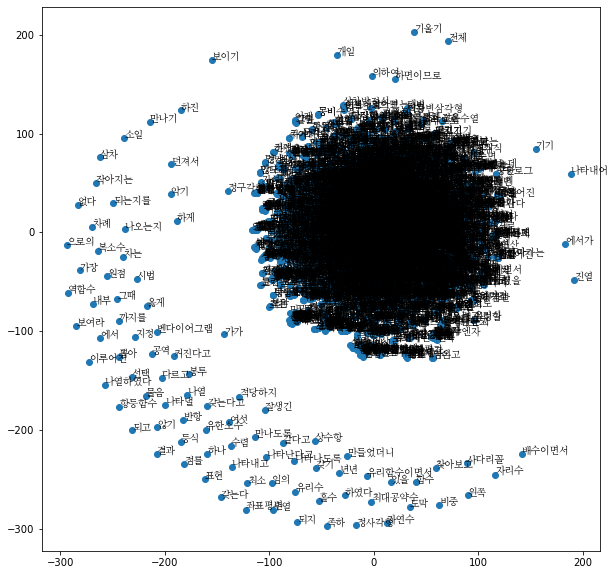

In [45]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams["figure.figsize"] = (10,10)
path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
fontprop = fm.FontProperties(fname=path, size=10)
plt.scatter(Z[:,0], Z[:,1])
for i in range(len(tfidf_dict)):
    plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]),fontProperties =fontprop)

plt.draw()

# hwp파일 불러와서 text에 저장

In [ ]:
from urllib.request import Request, urlopen 
import olefile

# header = {'User-Agent': 'Mozilla/5.0'}
with open("hwptest1.txt", mode="w") as file:
    
    file.write("START\n")
    
    for u in sample_hwp_list:

        temp = Request(u)
        
        try:
            temp = urlopen(temp).read()
        
            f = olefile.OleFileIO(temp)
        
    
            encoded_text = f.openstream('PrvText').read()
            decoded_text = encoded_text.decode('UTF-16')
        
            file.writelines(decoded_text)
            file.write("\n")
        
        except:
            print(u,"을 불러올 수 없습니다.")
        
    file.write("END")

In [20]:
from konlpy.tag import Okt

okt = Okt()

In [21]:
okt.pos(decoded_text,norm=True,stem = True) 

[('에', 'Josa'),
 ('자연수', 'Noun'),
 ('를', 'Josa'),
 ('곱', 'Noun'),
 ('하다', 'Verb'),
 ('어떻다', 'Adjective'),
 ('수의', 'Noun'),
 ('제곱', 'Noun'),
 ('이', 'Josa'),
 ('되다', 'Verb'),
 ('하다', 'Verb'),
 ('하다', 'Verb'),
 ('.', 'Punctuation'),
 ('제곱', 'Noun'),
 ('이', 'Josa'),
 ('되다', 'Verb'),
 ('하다', 'Verb'),
 ('위해', 'Noun'),
 ('서', 'Josa'),
 ('곱', 'Noun'),
 ('하다', 'Verb'),
 ('수', 'Noun'),
 ('중', 'Noun'),
 ('첫', 'Noun'),
 ('번', 'Noun'),
 ('째', 'Suffix'),
 ('로', 'Josa'),
 ('작다', 'Adjective'),
 ('수', 'Noun'),
 ('와', 'Josa'),
 ('세', 'Noun'),
 ('번', 'Noun'),
 ('째', 'Suffix'),
 ('로', 'Josa'),
 ('작다', 'Adjective'),
 ('수', 'Noun'),
 ('를', 'Josa'),
 ('구', 'Noun'),
 ('하다', 'Verb'),
 ('.', 'Punctuation'),
 ('\r\n', 'Foreign')]

In [25]:
from soynlp.noun import LRNounExtractor

In [26]:
from soynlp.tokenizer import RegexTokenizer, LTokenizer, MaxScoreTokenizer

tokenizer = RegexTokenizer()

/home/master/anaconda3/envs/py37/lib/python3.7/site-packages/soynlp/tokenizer/_tokenizer.py:19: FutureWarning: Possible nested set at position 13
  ('english & latin', re.compile(u"[a-zA-ZÀ-ÿ]+[[`']?s]*|[a-zA-ZÀ-ÿ]+", re.UNICODE))


In [25]:
decoded_text ='에 자연수를 곱하여 어떤 수의 제곱이 되도록 하려고 한다. 제곱이 되도록 하기 위해서 곱하는 수 중 첫 번째로 작은 수와 세 번째로 작은 수를 구하시오.\r\n'

In [29]:
tokened_title = tokenizer.tokenize(decoded_text,stem=True)

TypeError: tokenize() got an unexpected keyword argument 'stem'

In [28]:
print(tokened_title)

['에', '자연수를', '곱하여', '어떤', '수의', '제곱이', '되도록', '하려고', '한다', '.', '제곱이', '되도록', '하기', '위해서', '곱하는', '수', '중', '첫', '번째로', '작은', '수와', '세', '번째로', '작은', '수를', '구하시오', '.']


In [51]:
!pip install eunjeon

In [52]:
from konlpy.tag import Twitter

In [54]:
twt = Twitter()
tagging = twt.pos(decoded_text)

In [55]:
tagging

[('에', 'Josa'),
 ('자연수', 'Noun'),
 ('를', 'Josa'),
 ('곱', 'Noun'),
 ('하여', 'Verb'),
 ('어떤', 'Adjective'),
 ('수의', 'Noun'),
 ('제곱', 'Noun'),
 ('이', 'Josa'),
 ('되도록', 'Verb'),
 ('하려고', 'Verb'),
 ('한다', 'Verb'),
 ('.', 'Punctuation'),
 ('제곱', 'Noun'),
 ('이', 'Josa'),
 ('되도록', 'Verb'),
 ('하기', 'Verb'),
 ('위해', 'Noun'),
 ('서', 'Josa'),
 ('곱', 'Noun'),
 ('하는', 'Verb'),
 ('수', 'Noun'),
 ('중', 'Noun'),
 ('첫', 'Noun'),
 ('번', 'Noun'),
 ('째', 'Suffix'),
 ('로', 'Josa'),
 ('작은', 'Adjective'),
 ('수', 'Noun'),
 ('와', 'Josa'),
 ('세', 'Noun'),
 ('번', 'Noun'),
 ('째', 'Suffix'),
 ('로', 'Josa'),
 ('작은', 'Adjective'),
 ('수', 'Noun'),
 ('를', 'Josa'),
 ('구', 'Noun'),
 ('하시오', 'Verb'),
 ('.', 'Punctuation'),
 ('\r\n', 'Foreign')]

In [56]:
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Hannanum

kkma = Kkma()
kom = Komoran()
hann = Hannanum()

In [57]:
kkma_tagger = kkma.pos(decoded_text)
kkma_tagger

[('에', 'JC'),
 ('자연수', 'NNG'),
 ('를', 'JKO'),
 ('곱하', 'VV'),
 ('여', 'ECS'),
 ('어떤', 'MDT'),
 ('수의', 'NNG'),
 ('제곱', 'NNG'),
 ('이', 'JKC'),
 ('되', 'VV'),
 ('도록', 'ECD'),
 ('하', 'VV'),
 ('려고', 'ECD'),
 ('하', 'VV'),
 ('ㄴ다', 'EFN'),
 ('.', 'SF'),
 ('제곱', 'NNG'),
 ('이', 'JKC'),
 ('되', 'VV'),
 ('도록', 'ECD'),
 ('하', 'VV'),
 ('기', 'ETN'),
 ('위하', 'VV'),
 ('어서', 'ECD'),
 ('곱하', 'VV'),
 ('는', 'ETD'),
 ('수', 'NNB'),
 ('중', 'NNB'),
 ('첫', 'MDT'),
 ('번째', 'NNB'),
 ('로', 'JKM'),
 ('작', 'VA'),
 ('은', 'ETD'),
 ('수', 'NNB'),
 ('와', 'JKM'),
 ('세', 'MDN'),
 ('번째', 'NNB'),
 ('로', 'JKM'),
 ('작', 'VA'),
 ('은', 'ETD'),
 ('수', 'NNB'),
 ('를', 'JKO'),
 ('구하', 'VV'),
 ('시', 'EPH'),
 ('오', 'EFN'),
 ('.', 'SF')]

In [66]:
sentance = decoded_text
kom_tagger = kom.pos(sentance)
kom_tagger

[('에', 'JKB'),
 ('자연수', 'NNP'),
 ('를', 'JKO'),
 ('곱하', 'VV'),
 ('아', 'EC'),
 ('어떤', 'MM'),
 ('수', 'NNB'),
 ('의', 'JKG'),
 ('제곱', 'NNG'),
 ('이', 'JKS'),
 ('되', 'VV'),
 ('도록', 'EC'),
 ('하', 'VV'),
 ('려고', 'EC'),
 ('하', 'VX'),
 ('ㄴ다', 'EF'),
 ('.', 'SF'),
 ('제곱', 'NNG'),
 ('이', 'JKS'),
 ('되', 'VV'),
 ('도록', 'EC'),
 ('하', 'VV'),
 ('기', 'ETN'),
 ('위하', 'VV'),
 ('아서', 'EC'),
 ('곱하', 'VV'),
 ('는', 'ETM'),
 ('수', 'NNB'),
 ('중', 'NNB'),
 ('첫', 'MM'),
 ('번', 'NNB'),
 ('째', 'XSN'),
 ('로', 'JKB'),
 ('작은 수', 'NNP'),
 ('와', 'JC'),
 ('세', 'MM'),
 ('번', 'NNB'),
 ('째', 'XSN'),
 ('로', 'JKB'),
 ('작은 수', 'NNP'),
 ('를', 'JKO'),
 ('구하', 'VV'),
 ('시', 'EP'),
 ('오', 'EF'),
 ('.', 'SF')]

In [60]:
hann_tagger = hann.pos(sentance)
hann_tagger

[('에', 'P'),
 ('어', 'E'),
 ('자연수', 'N'),
 ('를', 'J'),
 ('곱', 'N'),
 ('하', 'X'),
 ('어', 'E'),
 ('어떤', 'M'),
 ('수', 'N'),
 ('의', 'J'),
 ('제곱', 'N'),
 ('이', 'J'),
 ('되', 'P'),
 ('도록', 'E'),
 ('하', 'P'),
 ('려고', 'E'),
 ('하', 'P'),
 ('ㄴ다', 'E'),
 ('.', 'S'),
 ('제곱', 'N'),
 ('이', 'J'),
 ('되', 'P'),
 ('도록', 'E'),
 ('하', 'P'),
 ('기', 'E'),
 ('위하', 'P'),
 ('어서', 'E'),
 ('곱', 'N'),
 ('하', 'X'),
 ('는', 'E'),
 ('수', 'N'),
 ('중', 'N'),
 ('첫', 'N'),
 ('번', 'N'),
 ('째', 'X'),
 ('로', 'J'),
 ('작', 'P'),
 ('은', 'E'),
 ('수', 'N'),
 ('와', 'J'),
 ('세', 'N'),
 ('번', 'N'),
 ('째', 'X'),
 ('로', 'J'),
 ('작', 'P'),
 ('은', 'E'),
 ('수', 'N'),
 ('를', 'J'),
 ('구하', 'P'),
 ('시오', 'E'),
 ('.', 'S')]

In [61]:
kkma = Kkma()
kom = Komoran()
hann = Hannanum()
kkma_nouns = [n for n, tag in kkma_tagger if tag == 'Noun']
kom_nouns = [n for n, tag in kom_tagger if tag == 'Noun']
hann_nouns = [n for n, tag in hann_tagger if tag == 'Noun']

In [63]:
twt_nouns = [n for n, tag in tagging if tag == 'Noun']

In [64]:
twt_nouns

['자연수',
 '곱',
 '수의',
 '제곱',
 '제곱',
 '위해',
 '곱',
 '수',
 '중',
 '첫',
 '번',
 '수',
 '세',
 '번',
 '수',
 '구']